Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


### Importing Skin Cancer Data




### Importing all the important libraries


In [14]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [15]:
## If you are using the data by mounting the google drive, use the following :

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Data has been downloaded and stored in a folder 'images' divided into 'train' and 'test' folder.


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.


In [16]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Test")

In [17]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.


### Create a dataset

Define some parameters for the loader:


In [18]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.


In [19]:
## Train dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [20]:
## Validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [21]:
# List out all the classes of skin cancer and store them in a list.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data




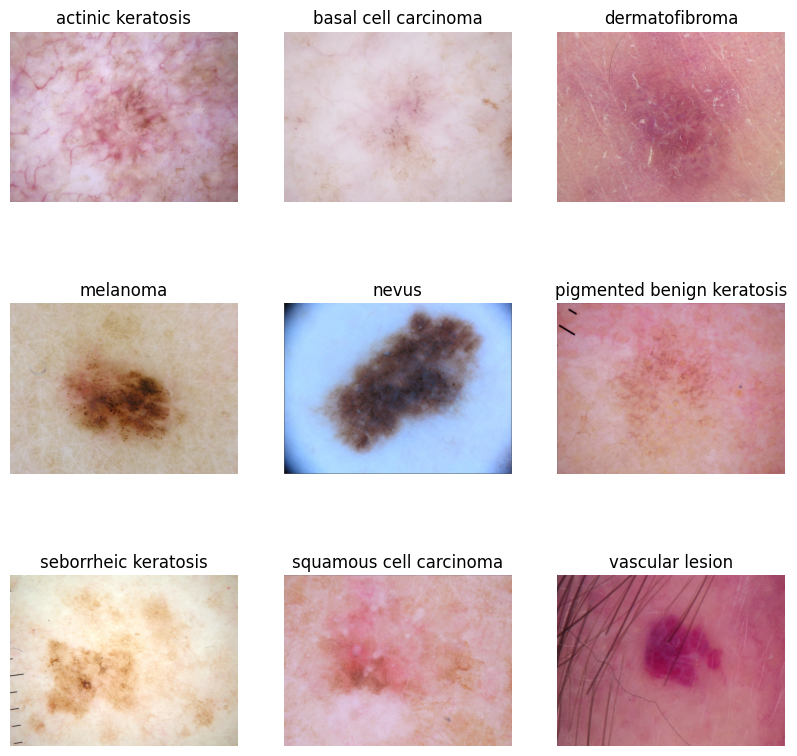

In [22]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use `layers.experimental.preprocessing.Rescaling` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`


In [24]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))

model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(11,11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

### Compile the model

Choose an appropirate optimiser and loss function for model training


In [25]:

learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [26]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

### Train the model


In [27]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 544s 3s/step - loss: 2.0589 - accuracy: 0.1825 - val_loss: 2.0510 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 3s 51ms/step - loss: 2.0316 - accuracy: 0.1970 - val_loss: 2.0386 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 3s 53ms/step - loss: 1.9902 - accuracy: 0.2333 - val_loss: 2.0054 - val_accuracy: 0.2282 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 3s 53ms/step - loss: 1.9536 - accuracy: 0.2411 - val_loss: 1.8699 - val_accuracy: 0.3289 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 3s 49ms/step - loss: 1.8166 - accuracy: 0.3214 - val_loss: 1.7917 - val_accuracy: 0.3020 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 3s 48ms/step - loss: 1.7497 - accuracy: 0.3298 - val_loss: 1.6694 - val_accuracy: 0.3624 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 3s 48ms/step - loss: 1.6

### Visualizing training results


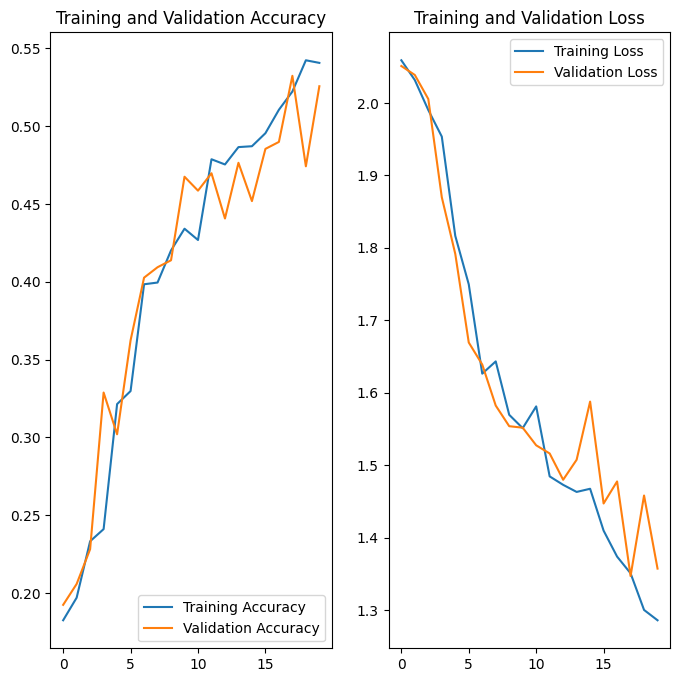

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings**

1. Traing accuracy and validation accuracy are similar. But the accuracy is not great which indicates that the model is underfitting
2. Loss is low and validation loss is fluctuating as epochs increase

Conclusion: Model accuracy has to be improved


In [29]:
# Data augumentation strategy
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomRotation(0.15),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")

  ]
)

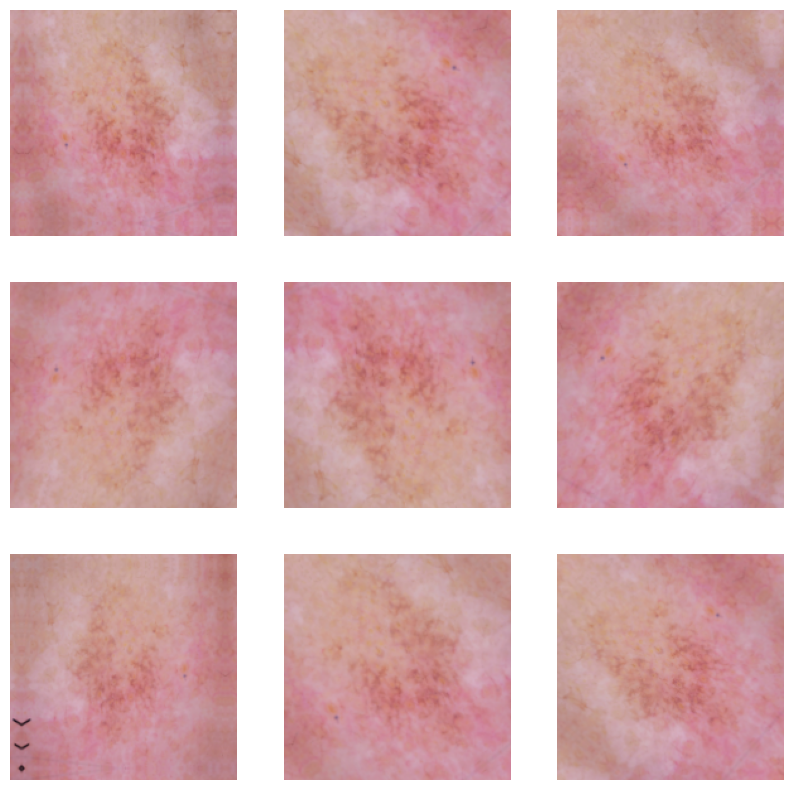

In [30]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model


In [31]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))

model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(11,11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

### Compiling the model


In [32]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [33]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

### Training the model


In [34]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 5s 56ms/step - loss: 2.0570 - accuracy: 0.1869 - val_loss: 2.0509 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 3s 54ms/step - loss: 2.0402 - accuracy: 0.2059 - val_loss: 2.0360 - val_accuracy: 0.2125 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.8676 - accuracy: 0.2868 - val_loss: 1.8526 - val_accuracy: 0.2931 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.7161 - accuracy: 0.3465 - val_loss: 1.6212 - val_accuracy: 0.4027 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 3s 46ms/step - loss: 1.6266 - accuracy: 0.3890 - val_loss: 1.6033 - val_accuracy: 0.4139 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 3s 50ms/step - loss: 1.6193 - accuracy: 0.3934 - val_loss: 1.7053 - val_accuracy: 0.3714 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.6

### Visualizing the results


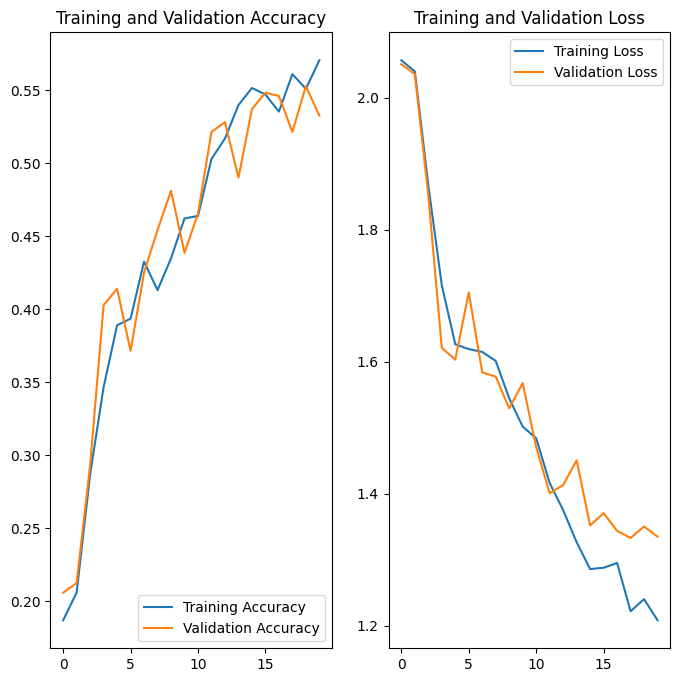

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings**

1. There is small drop in accuracy. But accuracy is increasing with epochs. So we should explore adding more epochs and check for class imbalance.


#### Find the distribution of classes in the training dataset.

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.


<ipython-input-36-9abe01dbce99>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_dstr=class_dstr.append({'class':class_nm,'number':samples},ignore_index=True)
<ipython-input-36-9abe01dbce99>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_dstr=class_dstr.append({'class':class_nm,'number':samples},ignore_index=True)
<ipython-input-36-9abe01dbce99>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_dstr=class_dstr.append({'class':class_nm,'number':samples},ignore_index=True)
<ipython-input-36-9abe01dbce99>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_dstr=class_dstr.append({'class':class_nm,'number':samples},ign

<function matplotlib.pyplot.show(close=None, block=None)>

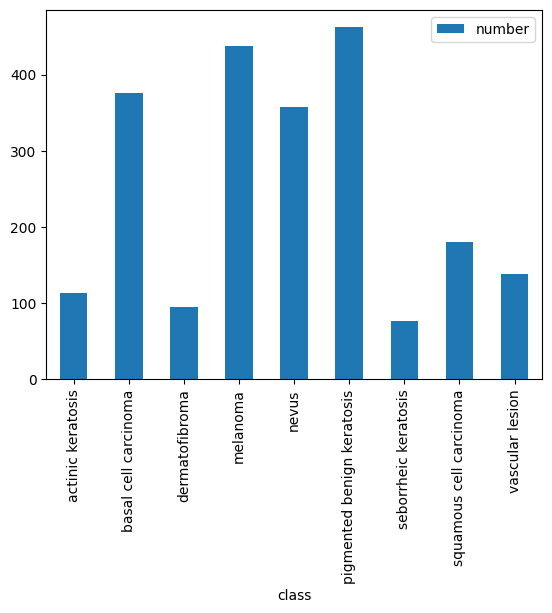

In [36]:

class_dstr=pd.DataFrame()

for i in range(len(class_names)):
  class_nm = class_names[i]
  samples = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_dstr=class_dstr.append({'class':class_nm,'number':samples},ignore_index=True)

class_dstr.plot.bar(x='class',y='number',rot=90)
plt.show

**Findings**

#### - Which class has the least number of samples?

#### **Ans.** seborrheic keratosis

#### - Which classes dominate the data in terms proportionate number of samples?

#### **Ans.** pigmented benign keratosis


#### Rectify the class imbalance

#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.


In [37]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [38]:
path_to_training_dataset="/content/gdrive/MyDrive/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DA3C5E4FD30>: 100%|██████████| 500/500 [00:21<00:00, 22.84 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DA3C5F66E00>: 100%|██████████| 500/500 [00:27<00:00, 18.40 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DA3C5F02500>: 100%|██████████| 500/500 [00:25<00:00, 19.30 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DA3C5FA96F0>: 100%|██████████| 500/500 [01:23<00:00,  6.02 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2012x1956 at 0x7DA458451990>: 100%|██████████| 500/500 [01:15<00:00,  6.62 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DA3F71629E0>: 100%|██████████| 500/500 [00:18<00:00, 27.67 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DA4500BF9A0>: 100%|██████████| 500/500 [00:42<00:00, 11.90 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DA3C9D02680>: 100%|██████████| 500/500 [00:18<00:00, 27.46 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DA3C5E7E290>: 100%|██████████| 500/500 [00:17<00:00, 28.74 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.


In [39]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.


In [40]:
from glob import glob

path_list_new = list(glob(os.path.join(data_dir_train, '*','output', '*.jpg')))
path_list_new

['/content/gdrive/MyDrive/Train/melanoma/output/melanoma_original_ISIC_0010543.jpg_5011eeea-ddb6-4059-b3f2-7452b538bb70.jpg',
 '/content/gdrive/MyDrive/Train/melanoma/output/melanoma_original_ISIC_0010655.jpg_c480224f-410b-42b3-befd-c8fa80c8b254.jpg',
 '/content/gdrive/MyDrive/Train/melanoma/output/melanoma_original_ISIC_0010392.jpg_2d641f4b-01be-4b99-890f-fd8a908f7065.jpg',
 '/content/gdrive/MyDrive/Train/melanoma/output/melanoma_original_ISIC_0000466.jpg_010ecf6a-9cc0-4cbe-af1f-7877c8514d76.jpg',
 '/content/gdrive/MyDrive/Train/melanoma/output/melanoma_original_ISIC_0009934.jpg_e1775658-c66d-47c9-9fa6-2ff49efc4f55.jpg',
 '/content/gdrive/MyDrive/Train/melanoma/output/melanoma_original_ISIC_0010503.jpg_7b9dc71b-7eed-4a56-b694-839f8ab148ad.jpg',
 '/content/gdrive/MyDrive/Train/melanoma/output/melanoma_original_ISIC_0010912.jpg_88dfb830-a75c-4037-adc9-be94235f84eb.jpg',
 '/content/gdrive/MyDrive/Train/melanoma/output/melanoma_original_ISIC_0010630.jpg_446f7f1e-ff08-4364-b236-10a3c52855b

In [41]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [42]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [43]:
for i in class_names:
    org_dir ='/content/gdrive/MyDrive/Train/'
    add_dir ='/content/gdrive/MyDrive/Train/'+'/'+i+'/output/'
    img_org_dir = pathlib.Path(org_dir)
    img_add_dir = pathlib.Path(add_dir)
    org_length=len(list(img_org_dir.glob(i+'/*.jpg')))
    add_length=len(list(img_add_dir.glob('*.jpg')))
    print(f'{i} - original -  {org_length} ')
    length=org_length+add_length
    print(f'{i} - new - {length} ')

actinic keratosis - original -  114 
actinic keratosis - new - 614 
basal cell carcinoma - original -  376 
basal cell carcinoma - new - 876 
dermatofibroma - original -  95 
dermatofibroma - new - 595 
melanoma - original -  438 
melanoma - new - 938 
nevus - original -  357 
nevus - new - 857 
pigmented benign keratosis - original -  462 
pigmented benign keratosis - new - 962 
seborrheic keratosis - original -  77 
seborrheic keratosis - new - 577 
squamous cell carcinoma - original -  181 
squamous cell carcinoma - new - 681 
vascular lesion - original -  139 
vascular lesion - new - 639 


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.


#### Train the model on the data created using Augmentor


In [44]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset


In [45]:
data_dir_train="/content/gdrive/MyDrive/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset


In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)


In [47]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))

model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(11,11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization (Batch  (None, 90, 90, 32)        128       
 Normalization)                                                  
                                                                 
 dropout_12 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)       

#### Compile your model (Choose optimizer and loss function appropriately)


In [49]:
### Choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [50]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization (Batch  (None, 90, 90, 32)        128       
 Normalization)                                                  
                                                                 
 dropout_12 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)       

#### Train your model


In [51]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/50
169/169 [==============================] - 46s 240ms/step - loss: 1.7692 - accuracy: 0.3841 - val_loss: 2.5188 - val_accuracy: 0.1811 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 36s 208ms/step - loss: 1.4828 - accuracy: 0.4655 - val_loss: 2.9363 - val_accuracy: 0.1403 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 41s 234ms/step - loss: 1.3020 - accuracy: 0.5174 - val_loss: 1.7595 - val_accuracy: 0.3734 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 36s 205ms/step - loss: 1.1518 - accuracy: 0.5684 - val_loss: 1.6809 - val_accuracy: 0.3987 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 36s 205ms/step - loss: 0.9567 - accuracy: 0.6391 - val_loss: 1.5401 - val_accuracy: 0.4239 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 36s 208ms/step - loss: 0.8585 - accuracy: 0.6767 - val_loss: 2.6595 - val_accuracy: 0.3571 - lr: 0.0010
Epoch 7/50
169/169 [==============================] 

#### **Todo:** Visualize the model results


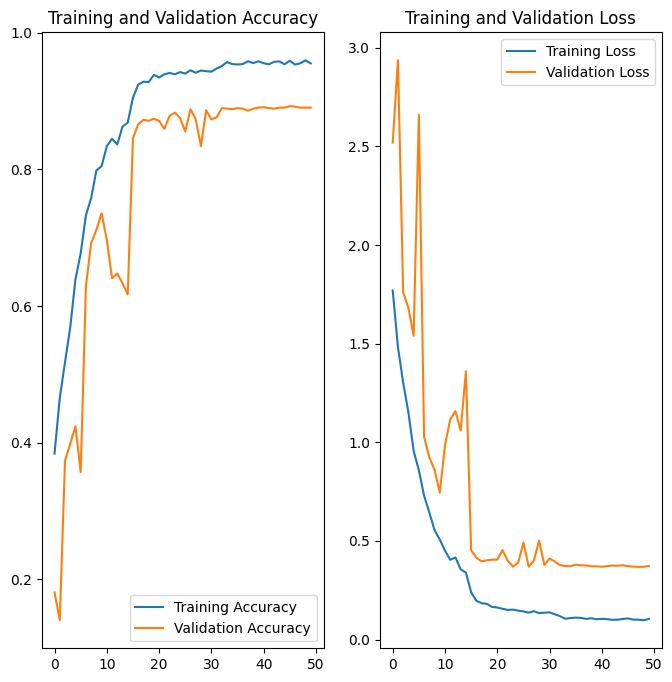

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings**
1. Fixing class imbalance was helpful
2. The training accuracy is 0.95 and validation accuracy is 0.89
3. The Validation accuracy is 0.87 which is good. The model is able to classify the images with 87% accuracy.